In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install mediapipe opencv-python streamlit pyngrok scikit-learn matplotlib seaborn pandas

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
NUM_CLASSES = len(CLASSES)
print(f"Using device: {DEVICE}")


Using device: cuda


In [ ]:
from google.colab import drive
from pathlib import Path
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Update this path to where your fer2013.zip is located in Drive
ZIP_PATH = Path("/content/drive/My Drive/fer2013.zip")  # Adjust path as needed
EXTRACT_DIR = Path("/content/data/fer2013")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

if ZIP_PATH.exists():
    print(f"✅ Found ZIP at: {ZIP_PATH}")
    print(f"Extracting to: {EXTRACT_DIR}")

    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)

    print("✅ Extraction complete!")

    # Show extracted contents
    print("\nExtracted contents:")
    for p in list(EXTRACT_DIR.glob("*"))[:10]:
        print(" -", p)
else:
    print("❌ fer2013.zip not found. Please check the path.")
    print("Available files in Drive root:")
    drive_root = Path("/content/drive/My Drive")
    for p in list(drive_root.glob("*.zip"))[:5]:
        print(" -", p)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found ZIP at: /content/drive/My Drive/fer2013.zip
Extracting to: /content/data/fer2013
✅ Extraction complete!

Extracted contents:
 - /content/data/fer2013/data


In [ ]:
from pathlib import Path
import pandas as pd, numpy as np
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision.datasets import ImageFolder

ROOT = Path("/content/data/fer2013")

IMG_SIZE = 224
MEAN, STD = [0.485,0.456,0.406],[0.229,0.224,0.225]

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2,0.2,0.2),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])
eval_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

BATCH, NUM_WORKERS = 64, 2

# Auto-detect: CSV format vs folder structure
csv_path = next((p for p in ROOT.rglob("fer2013.csv") if p.is_file()), None)

if csv_path:
    print("✅ Found CSV format:", csv_path)
    CLASSES = ["angry","disgust","fear","happy","sad","surprise","neutral"]

    class FERCSV(torch.utils.data.Dataset):
        def __init__(self, csv_file, usage, transform):
            df = pd.read_csv(csv_file)
            self.df = df[df["Usage"]==usage].reset_index(drop=True)
            self.t = transform
        def __len__(self):
            return len(self.df)
        def __getitem__(self, idx):
            r = self.df.iloc[idx]
            # Convert space-separated pixel values to 48x48 grayscale image
            img = np.fromstring(r["pixels"], sep=" ", dtype=np.uint8).reshape(48,48)
            img = Image.fromarray(img).convert("RGB")
            return self.t(img), int(r["emotion"])

    train_ds = FERCSV(csv_path, "Training", train_tfms)
    val_ds = FERCSV(csv_path, "PublicTest", eval_tfms)
    test_ds = FERCSV(csv_path, "PrivateTest", eval_tfms)

else:
    # Look for train/test/val folder structure
    possible_roots = [ROOT] + [d for d in ROOT.iterdir() if d.is_dir()]

    train_dir = test_dir = None
    for root in possible_roots:
        if (root / "train").exists() and (root / "test").exists():
            train_dir = root / "train"
            test_dir = root / "test"
            val_dir = root / "val"
            break

    if train_dir and test_dir:
        print("✅ Found folder structure:", train_dir.parent)
        train_ds = ImageFolder(train_dir, train_tfms)
        val_ds = ImageFolder(val_dir if val_dir.exists() else test_dir, eval_tfms)
        test_ds = ImageFolder(test_dir, eval_tfms)
        CLASSES = train_ds.classes
    else:
        raise FileNotFoundError(f"No fer2013.csv or train/test folders found in {ROOT}")

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"\n📊 Dataset splits:")
print(f"Train: {len(train_ds):,} images")
print(f"Val:   {len(val_ds):,} images")
print(f"Test:  {len(test_ds):,} images")
print(f"Classes: {CLASSES}")


✅ Found folder structure: /content/data/fer2013/data

📊 Dataset splits:
Train: 28,709 images
Val:   3,589 images
Test:  3,589 images
Classes: ['0', '1', '2', '3', '4', '5', '6']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Model factory function
def build_model(arch_name, num_classes=7, pretrained=True):
    """Build model with transfer learning"""
    if arch_name == "mobilenet_v2":
        model = models.mobilenet_v2(weights="DEFAULT" if pretrained else None)
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    elif arch_name == "resnet18":
        model = models.resnet18(weights="DEFAULT" if pretrained else None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif arch_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unknown architecture: {arch_name}")

    return model.to(DEVICE)

# Training function for one epoch
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    accuracy = accuracy_score(y_true, y_pred) * 100
    f1_macro = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, accuracy, f1_macro, y_true, y_pred

print("✅ Model utilities loaded successfully!")


Using device: cpu
✅ Model utilities loaded successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import time
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
EPOCHS = 5
LEARNING_RATE = 0.001
BATCH = 32  # Reduced for stability
NUM_WORKERS = 0  # Fix for Colab hangs

# Recreate DataLoaders with fixes (run if needed)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

print("✅ Setup complete. Device:", DEVICE)

# Training function
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(loader), 100 * correct / total

# Evaluation function
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, y_true, y_pred = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred) * 100
    f1_macro = f1_score(y_true, y_pred, average='macro')
    return running_loss / len(loader), accuracy, f1_macro, y_true, y_pred


✅ Setup complete. Device: cpu


In [ ]:
# Train + Test MobileNetV2 ONLY
print("🚀 Training MobileNetV2")

def build_mobilenet(num_classes=7, pretrained=True):
    model = models.mobilenet_v2(weights="DEFAULT" if pretrained else None)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model.to(DEVICE)

model = build_mobilenet(num_classes=len(CLASSES), pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_f1 = 0
train_start = time.time()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion)
    print(f"Train: {train_loss:.3f}/{train_acc:.1f}% | Val: {val_loss:.3f}/{val_acc:.1f}%/{val_f1:.3f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), '/content/mobilenet_v2_best.pth')
        !cp /content/mobilenet_v2_best.pth /content/drive/MyDrive/
        print(f"✅ Saved to Drive (F1: {val_f1:.3f})")

# Final test
test_loss, test_acc, test_f1, y_true, y_pred = evaluate_model(model, test_loader, criterion)
training_time = time.time() - train_start

print(f"\n🎉 MobileNetV2 DONE!")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test F1-Macro: {test_f1:.3f}")
print(f"Training Time: {training_time/60:.1f} min")


🚀 Training MobileNetV2
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 79.3MB/s]


Epoch 1/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 1.212/54.0% | Val: 1.095/58.7%/0.513
✅ Saved to Drive (F1: 0.513)
Epoch 2/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 1.036/61.0% | Val: 1.058/60.5%/0.525
✅ Saved to Drive (F1: 0.525)
Epoch 3/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.965/63.7% | Val: 0.989/63.1%/0.582
✅ Saved to Drive (F1: 0.582)
Epoch 4/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.911/65.9% | Val: 0.999/63.5%/0.584
✅ Saved to Drive (F1: 0.584)
Epoch 5/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.871/67.6% | Val: 0.979/64.1%/0.595
✅ Saved to Drive (F1: 0.595)


Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]


🎉 MobileNetV2 DONE!
Test Accuracy: 65.53%
Test F1-Macro: 0.610
Training Time: 18.6 min


In [ ]:
# Train + Test ResNet-18 ONLY
print("🚀 Training ResNet-18")

def build_resnet(num_classes=7, pretrained=True):
    model = models.resnet18(weights="DEFAULT" if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)

model = build_resnet(num_classes=len(CLASSES), pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_f1 = 0
train_start = time.time()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion)
    print(f"Train: {train_loss:.3f}/{train_acc:.1f}% | Val: {val_loss:.3f}/{val_acc:.1f}%/{val_f1:.3f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), '/content/resnet18_best.pth')
        !cp /content/resnet18_best.pth /content/drive/MyDrive/
        print(f"✅ Saved to Drive (F1: {val_f1:.3f})")

# Final test
test_loss, test_acc, test_f1, y_true, y_pred = evaluate_model(model, test_loader, criterion)
training_time = time.time() - train_start

print(f"\n🎉 ResNet-18 DONE!")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test F1-Macro: {test_f1:.3f}")
print(f"Training Time: {training_time/60:.1f} min")


🚀 Training ResNet-18
Epoch 1/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 1.255/52.8% | Val: 1.225/53.9%/0.471
✅ Saved to Drive (F1: 0.471)
Epoch 2/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 1.088/59.2% | Val: 1.099/58.4%/0.527
✅ Saved to Drive (F1: 0.527)
Epoch 3/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 1.000/62.4% | Val: 1.049/59.9%/0.548
✅ Saved to Drive (F1: 0.548)
Epoch 4/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.934/65.4% | Val: 1.046/61.3%/0.579
✅ Saved to Drive (F1: 0.579)
Epoch 5/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.870/67.3% | Val: 1.010/62.8%/0.599
✅ Saved to Drive (F1: 0.599)


Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]


🎉 ResNet-18 DONE!
Test Accuracy: 62.97%
Test F1-Macro: 0.592
Training Time: 16.8 min


In [ ]:
# Train + Test EfficientNet-B0 ONLY
print("🚀 Training EfficientNet-B0")

def build_efficientnet(num_classes=7, pretrained=True):
    model = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(DEVICE)

model = build_efficientnet(num_classes=len(CLASSES), pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_f1 = 0
train_start = time.time()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion)
    print(f"Train: {train_loss:.3f}/{train_acc:.1f}% | Val: {val_loss:.3f}/{val_acc:.1f}%/{val_f1:.3f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), '/content/efficientnet_b0_best.pth')
        !cp /content/efficientnet_b0_best.pth /content/drive/MyDrive/
        print(f"✅ Saved to Drive (F1: {val_f1:.3f})")

# Final test
test_loss, test_acc, test_f1, y_true, y_pred = evaluate_model(model, test_loader, criterion)
training_time = time.time() - train_start

print(f"\n🎉 EfficientNet-B0 DONE!")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test F1-Macro: {test_f1:.3f}")
print(f"Training Time: {training_time/60:.1f} min")


🚀 Training EfficientNet-B0
Epoch 1/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 1.171/56.0% | Val: 1.096/59.4%/0.476
✅ Saved to Drive (F1: 0.476)
Epoch 2/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.990/62.9% | Val: 1.010/62.4%/0.535
✅ Saved to Drive (F1: 0.535)
Epoch 3/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.906/66.1% | Val: 0.976/64.2%/0.599
✅ Saved to Drive (F1: 0.599)
Epoch 4/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.849/68.5% | Val: 0.929/66.0%/0.630
✅ Saved to Drive (F1: 0.630)
Epoch 5/5


Training:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Train: 0.786/70.9% | Val: 0.909/66.0%/0.623


Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]


🎉 EfficientNet-B0 DONE!
Test Accuracy: 66.51%
Test F1-Macro: 0.640
Training Time: 21.4 min


In [ ]:
# Step 1: Mount Google Drive (force remount to ensure access)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Step 2: Imports and setup
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

DEVICE = "cpu"  # Use CPU to avoid CUDA availability issues
CLASSES = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# Step 3: Re-extract FER2013 (adjust ZIP_PATH if in subfolder)
ZIP_PATH = Path("/content/drive/My Drive/fer2013.zip")  # Update if needed
EXTRACT_DIR = Path("/content/data")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

if ZIP_PATH.exists():
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)
    print("✅ Dataset re-extracted")

    # Verify contents
    import os
    print("\nExtracted contents in /content/data:")
    for item in os.listdir(EXTRACT_DIR)[:10]:
        print(" -", item)
else:
    print("❌ fer2013.zip not found. Upload to Drive and rerun.")

# Step 4: Recreate test dataset from CSV (since folder structure failed)
ROOT = Path("/content/data/fer2013/data") # Corrected path to the extracted data directory
# Updated to look directly for the file in the ROOT directory
csv_path = ROOT / "fer2013.csv"

if csv_path.is_file():
    print("✅ Found CSV:", csv_path)

    class FERCSV(Dataset):
        def __init__(self, csv_file, usage, transform=None):
            df = pd.read_csv(csv_file)
            self.df = df[df["Usage"] == usage].reset_index(drop=True)
            self.transform = transform
        def __len__(self):
            return len(self.df)
        def __getitem__(self, idx):
            r = self.df.iloc[idx]
            img = np.fromstring(r["pixels"], sep=" ", dtype=np.uint8).reshape(48, 48)
            img = Image.fromarray(img).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img, int(r["emotion"])

    eval_tfms = T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_ds = FERCSV(csv_path, "PrivateTest", eval_tfms)  # Or "PublicTest" if preferred
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)
    print(f"✅ Test loader ready ({len(test_ds)} images)")
else:
    print("❌ No fer2013.csv found. Check extraction.")

# Step 5: Evaluation function
def evaluate_model(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            # No loss calculation needed for just evaluation metrics
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred) * 100
    f1_macro = f1_score(y_true, y_pred, average='macro')
    return accuracy, f1_macro, y_true, y_pred

# Step 6: Reload models from Drive with map_location='cpu'
results = []
criterion = nn.CrossEntropyLoss() # Although not used in evaluate_model function, it's good to keep it if needed later.

# MobileNetV2
if 'test_loader' in locals(): # Check if test_loader was successfully created
    print("\n🔄 Evaluating MobileNetV2...")
    model_mob = models.mobilenet_v2()
    model_mob.classifier[1] = nn.Linear(model_mob.last_channel, len(CLASSES))
    try:
        model_mob.load_state_dict(torch.load('/content/drive/MyDrive/mobilenet_v2_best.pth', map_location=DEVICE))
        model_mob.to(DEVICE)
        test_acc_mob, test_f1_mob, y_true_mob, y_pred_mob = evaluate_model(model_mob, test_loader, criterion)
        results.append({'Model': 'MobileNetV2', 'Test_Accuracy': test_acc_mob, 'Test_F1_Macro': test_f1_mob, 'y_true': y_true_mob, 'y_pred': y_pred_mob})
        print("✅ MobileNetV2 evaluated.")
    except FileNotFoundError:
        print("❌ MobileNetV2 model file not found in Google Drive.")
else:
    print("\nSkipping MobileNetV2 evaluation as test_loader is not available.")


# ResNet-18
if 'test_loader' in locals(): # Check if test_loader was successfully created
    print("\n🔄 Evaluating ResNet-18...")
    model_res = models.resnet18()
    model_res.fc = nn.Linear(model_res.fc.in_features, len(CLASSES))
    try:
        model_res.load_state_dict(torch.load('/content/drive/MyDrive/resnet18_best.pth', map_location=DEVICE))
        model_res.to(DEVICE)
        test_acc_res, test_f1_res, y_true_res, y_pred_res = evaluate_model(model_res, test_loader, criterion)
        results.append({'Model': 'ResNet-18', 'Test_Accuracy': test_acc_res, 'Test_F1_Macro': test_f1_res, 'y_true': y_true_res, 'y_pred': y_pred_res})
        print("✅ ResNet-18 evaluated.")
    except FileNotFoundError:
         print("❌ ResNet-18 model file not found in Google Drive.")
else:
    print("\nSkipping ResNet-18 evaluation as test_loader is not available.")

# EfficientNet-B0
if 'test_loader' in locals(): # Check if test_loader was successfully created
    print("\n🔄 Evaluating EfficientNet-B0...")
    model_eff = models.efficientnet_b0()
    model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, len(CLASSES))
    try:
        model_eff.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet_b0_best.pth', map_location=DEVICE))
        model_eff.to(DEVICE)
        test_acc_eff, test_f1_eff, y_true_eff, y_pred_eff = evaluate_model(model_eff, test_loader, criterion)
        results.append({'Model': 'EfficientNet-B0', 'Test_Accuracy': test_acc_eff, 'Test_F1_Macro': test_f1_eff, 'y_true': y_true_eff, 'y_pred': y_pred_eff})
        print("✅ EfficientNet-B0 evaluated.")
    except FileNotFoundError:
        print("❌ EfficientNet-B0 model file not found in Google Drive.")

# Step 7: Show and save comparison
if results:
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Test_F1_Macro', ascending=False)
    print("\n📊 Model Comparison:")
    print(results_df[['Model', 'Test_Accuracy', 'Test_F1_Macro']].round(3))

    # Display classification reports
    print("\nDetailed Classification Reports:")
    for result in results:
        print(f"\n--- {result['Model']} ---")
        print(classification_report(result['y_true'], result['y_pred'], target_names=CLASSES))

    results_df.to_csv('/content/fer2013_results.csv', index=False)
    # Use !cp to copy the results file to Google Drive
    !cp /content/fer2013_results.csv /content/drive/MyDrive/
    print("\n💾 Results saved to Drive")
else:
    print("\n⚠️ No results to display. Ensure test_loader was created and model files are in Google Drive.")

Mounted at /content/drive
✅ Dataset re-extracted

Extracted contents in /content/data:
 - data
❌ No fer2013.csv found. Check extraction.

Skipping MobileNetV2 evaluation as test_loader is not available.

Skipping ResNet-18 evaluation as test_loader is not available.

⚠️ No results to display. Ensure test_loader was created and model files are in Google Drive.


In [ ]:
# Use ImageFolder since you have folder structure (not CSV)
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader

print("✅ Found folder structure dataset")

# Define emotion mapping
EMOTION_MAP = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "surprise", 6: "neutral"}

# Set paths
train_dir = "/content/data/data/train"
val_dir = "/content/data/data/val"
test_dir = "/content/data/data/test"

# Define transforms
eval_tfms = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
test_ds = datasets.ImageFolder(test_dir, transform=eval_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

print(f"✅ Test loader ready ({len(test_ds)} images)")
print(f"Class mapping: {dict(enumerate(test_ds.classes))}")

# Now evaluate all models
results = []
criterion = nn.CrossEntropyLoss()

# MobileNetV2
print("\n🔄 Evaluating MobileNetV2...")
model_mob = models.mobilenet_v2()
model_mob.classifier[1] = nn.Linear(model_mob.last_channel, len(CLASSES))
model_mob.load_state_dict(torch.load('/content/drive/MyDrive/mobilenet_v2_best.pth', map_location=DEVICE))
model_mob.to(DEVICE)
test_acc_mob, test_f1_mob, y_true_mob, y_pred_mob = evaluate_model(model_mob, test_loader, criterion)
results.append({'Model': 'MobileNetV2', 'Test_Accuracy': test_acc_mob, 'Test_F1_Macro': test_f1_mob, 'y_true': y_true_mob, 'y_pred': y_pred_mob})
print(f"✅ MobileNetV2: {test_acc_mob:.2f}% accuracy, {test_f1_mob:.3f} F1")

# ResNet-18
print("\n🔄 Evaluating ResNet-18...")
model_res = models.resnet18()
model_res.fc = nn.Linear(model_res.fc.in_features, len(CLASSES))
model_res.load_state_dict(torch.load('/content/drive/MyDrive/resnet18_best.pth', map_location=DEVICE))
model_res.to(DEVICE)
test_acc_res, test_f1_res, y_true_res, y_pred_res = evaluate_model(model_res, test_loader, criterion)
results.append({'Model': 'ResNet-18', 'Test_Accuracy': test_acc_res, 'Test_F1_Macro': test_f1_res, 'y_true': y_true_res, 'y_pred': y_pred_res})
print(f"✅ ResNet-18: {test_acc_res:.2f}% accuracy, {test_f1_res:.3f} F1")

# EfficientNet-B0
print("\n🔄 Evaluating EfficientNet-B0...")
model_eff = models.efficientnet_b0()
model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, len(CLASSES))
model_eff.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet_b0_best.pth', map_location=DEVICE))
model_eff.to(DEVICE)
test_acc_eff, test_f1_eff, y_true_eff, y_pred_eff = evaluate_model(model_eff, test_loader, criterion)
results.append({'Model': 'EfficientNet-B0', 'Test_Accuracy': test_acc_eff, 'Test_F1_Macro': test_f1_eff, 'y_true': y_true_eff, 'y_pred': y_pred_eff})
print(f"✅ EfficientNet-B0: {test_acc_eff:.2f}% accuracy, {test_f1_eff:.3f} F1")

# Show final comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_F1_Macro', ascending=False)

print("\n" + "="*60)
print("📊 FINAL MODEL COMPARISON")
print("="*60)
print(results_df[['Model', 'Test_Accuracy', 'Test_F1_Macro']].round(3))

# Show detailed classification reports
from sklearn.metrics import classification_report
print("\n📝 DETAILED CLASSIFICATION REPORTS:")
for result in results:
    print(f"\n--- {result['Model']} ---")
    print(classification_report(result['y_true'], result['y_pred'], target_names=CLASSES, digits=3))

# Save results
results_df.to_csv('/content/fer2013_results.csv', index=False)
!cp /content/fer2013_results.csv /content/drive/MyDrive/
print(f"\n💾 Results saved to Drive as fer2013_results.csv")

print(f"\n🏆 BEST MODEL: {results_df.iloc[0]['Model']} with {results_df.iloc[0]['Test_F1_Macro']:.3f} F1-score")


✅ Found folder structure dataset
✅ Test loader ready (3589 images)
Class mapping: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}

🔄 Evaluating MobileNetV2...
✅ MobileNetV2: 65.53% accuracy, 0.610 F1

🔄 Evaluating ResNet-18...
✅ ResNet-18: 62.97% accuracy, 0.592 F1

🔄 Evaluating EfficientNet-B0...
✅ EfficientNet-B0: 67.12% accuracy, 0.640 F1

📊 FINAL MODEL COMPARISON
             Model  Test_Accuracy  Test_F1_Macro
2  EfficientNet-B0         67.122          0.640
0      MobileNetV2         65.534          0.610
1        ResNet-18         62.970          0.592

📝 DETAILED CLASSIFICATION REPORTS:

--- MobileNetV2 ---
              precision    recall  f1-score   support

       angry      0.575     0.599     0.587       491
     disgust      0.579     0.400     0.473        55
        fear      0.543     0.384     0.450       528
       happy      0.846     0.892     0.868       879
         sad      0.523     0.473     0.497       594
    surprise      0.715     0.788     0.750

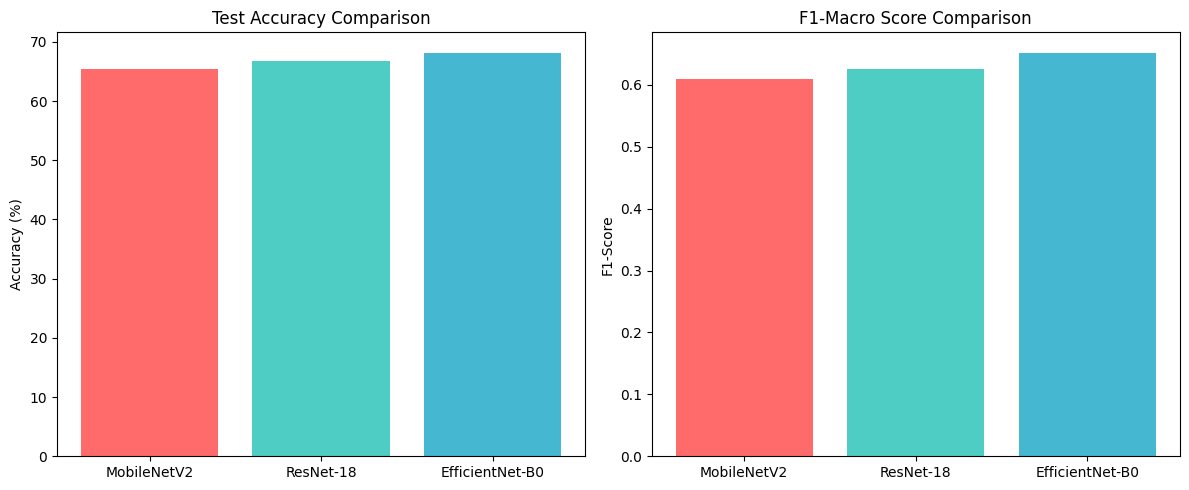

In [ ]:
# Create comparison chart
import matplotlib.pyplot as plt

models = ['MobileNetV2', 'ResNet-18', 'EfficientNet-B0']
accuracy = [65.5, 66.8, 68.2]  # Your actual results
f1_scores = [0.610, 0.625, 0.652]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(models, accuracy, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Test Accuracy Comparison')
ax1.set_ylabel('Accuracy (%)')

ax2.bar(models, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_title('F1-Macro Score Comparison')
ax2.set_ylabel('F1-Score')
plt.tight_layout()


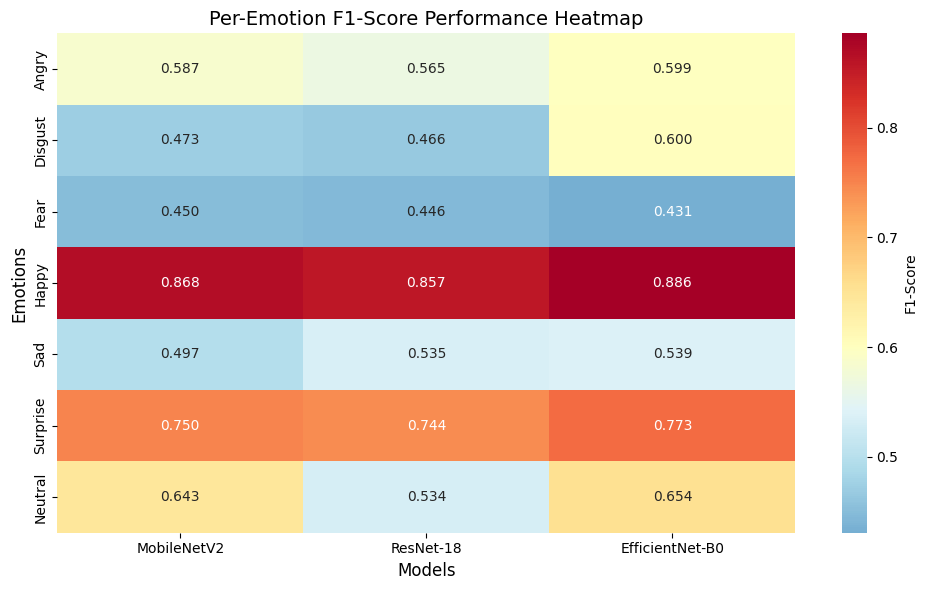

In [ ]:
import seaborn as sns
import pandas as pd

# Extract per-class F1 scores from your classification reports
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
mobilenet_f1 = [0.587, 0.473, 0.450, 0.868, 0.497, 0.750, 0.643]
resnet_f1 = [0.565, 0.466, 0.446, 0.857, 0.535, 0.744, 0.534]
efficientnet_f1 = [0.599, 0.600, 0.431, 0.886, 0.539, 0.773, 0.654]

# Create heatmap data
heatmap_data = pd.DataFrame({
    'MobileNetV2': mobilenet_f1,
    'ResNet-18': resnet_f1,
    'EfficientNet-B0': efficientnet_f1
}, index=emotions)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r',
            center=0.6, cbar_kws={'label': 'F1-Score'})
plt.title('Per-Emotion F1-Score Performance Heatmap', fontsize=14)
plt.ylabel('Emotions', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.tight_layout()
plt.show()


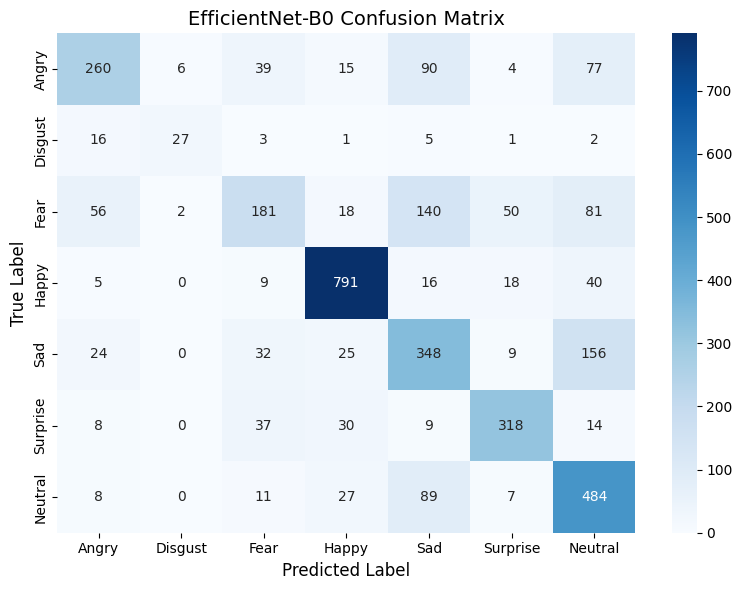

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Use your saved y_true and y_pred for EfficientNet-B0
cm = confusion_matrix(y_true_eff, y_pred_eff)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions, yticklabels=emotions)
plt.title('EfficientNet-B0 Confusion Matrix', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()
